# Chirp simulation

June 19, 2018

Reference: 
- [Sound Synthesis with Numpy](https://dzone.com/articles/sound-synthesis-numpy)
- [Decoding LoRa, a Wireless
Network for the Internet of Things](https://www.rsaconference.com/writable/presentations/file_upload/hta-f01-decoding-lora-a-wireless-network-for-the-internet-of-things_copy1.pdf)
- [LoRa Reverse Engineering and AES ](https://fosdem.org/2018/schedule/event/sdr_lora_aes/attachments/slides/2357/export/events/attachments/sdr_lora_aes/slides/2357/LoRa_AES_Security_SDR_FOSDEM_2018.pdf)
- [Radar Pulse Compression](https://www.ittc.ku.edu/workshops/Summer2004Lectures/Radar_Pulse_Compression.pdf)

## Conclusion of this simulation

In this simulation, Chirp compression in frequency domain (received signal * reference signal, then FFT) showed a better result than Chirp compression in time domain (reference signal as matched filter).

The best technique for my project: calculate FFT(received "real" chirp * reference "real" chirp), then find peaks around zero Hz in frequency domain. Adjust its time position by finding the strongest peak (it shoud be a single peak) for time frame synchronization between the transmitter and the receiver.

The reasons:
- DSP is a digital system for FFT/IFFT and filtering.
- CMSIS Real FFT API is faster than the Complex FFT API, and consumes less memory and time.

In [1]:
%matplotlib inline

from numpy import zeros, append, linspace, sin, cos, exp, pi, int16, abs, real, imag, random, sqrt
from scipy.io.wavfile import write
from scipy.signal import spectrogram
from scipy.fftpack import fft, ifft, fftfreq, fftshift
import matplotlib.pyplot as plt
import peakutils
import pandas
from IPython.display import display, Audio

In [2]:
SAMPLING_RATE = 8000  # Hz
SAMPLES = 2048
TIME_FRAME = SAMPLES/SAMPLING_RATE # Time frame in sec
AMPLITUDE = 20000 # 16bit PCM max amplitude

# Chirp sweep range in Hz
F1 = 220  # A3 tone
F2 = 440  # A4 tone

WAVE_FILE="./ChirpTone.wav"

## Chirp tone synthesis

In [3]:
# Complex version of chirp tone generator
def chirp(amp=AMPLITUDE, updown="up", length=TIME_FRAME, phase=-pi/2.0, rot=1.0):
    t = linspace(0, length, int(length * SAMPLING_RATE))
    delta = float(F2 - F1)/float(length)
    if (updown == "up"):
        freq = F1 + delta * t
    elif (updown == "down"):
        freq = F2 - delta * t
    arg = (2 * pi * freq * t) * rot + phase
    return exp(1j * arg) * amp

def chirp_cos(f1=F1, f2=F2, amp=AMPLITUDE, updown="up", length=TIME_FRAME, phase=-pi/2.0, rot=1.0):
    t = linspace(0, length, int(length * SAMPLING_RATE))
    delta = float(f2 - f1)/float(length)
    if (updown == "up"):
        freq = f1 + delta * t
    elif (updown == "down"):
        freq = f2 - delta * t
    arg = (2 * pi * freq * t) * rot + phase
    return cos(arg) * amp

def add_delay(chirp, delay_rate=0.0):
    l = len(chirp)
    la = int(l * delay_rate)
    a = zeros(la)
    b = zeros(2 * l - (l + la))
    return append(append(a, chirp), b)

# White noise generator
def white_noise(amp=AMPLITUDE, length=TIME_FRAME):
    a = random.random(int(length * SAMPLING_RATE)) * 2 * amp - amp
    # b = random.random(int(length * SAMPLING_RATE)) * 2 * amp - amp
    #return a + 1j * b
    return a

In [4]:
# Plot FFT frequency domain
def plot_fft(wave, thres=0.95):
    plt.figure(figsize=(8, 4), dpi=80)
    y = fftshift(fft(wave))
    freq = fftshift(fftfreq(len(y), 1/SAMPLING_RATE))

    a = abs(y)
    plt.plot(freq, a)
    plt.xlabel("Frequency(Hz)")
    plt.ylabel("Magnitude")
    plt.title("Frequency domain")

    freq = fftshift(fftfreq(len(y), 1/SAMPLING_RATE))
    print("Frequencies at peaks: {} Hz".format(freq[peakutils.indexes(a, thres=thres)]))

# Plot spectrogram
def plot_spectrogram(wave, nperseg, band):
    plt.figure(figsize=(8, 3), dpi=80)
    f, t, Sxx = spectrogram(real(wave), nperseg=nperseg, fs=SAMPLING_RATE)
    plt.pcolormesh(t, f[:band], Sxx[:band])
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title("Spectrogram")

# Plot wave
def plot_wave(wave, real_only=True):
    t = linspace(0, len(wave)/SAMPLING_RATE, len(wave))
    plt.figure(figsize=(8, 4), dpi=80)
    if real_only:
        plt.plot(t, real(wave))
    else:
        plt.plot(t, real(wave))
        plt.plot(t, imag(wave))
    plt.ylabel('Amplitude')
    plt.xlabel('Time [sec]')
    plt.title("Time domain")

# Playback chirp signal as tone
def play(wave):
    write(WAVE_FILE, SAMPLING_RATE, real(wave).astype(int16))
    display(Audio('./' + WAVE_FILE))

## Up chirp

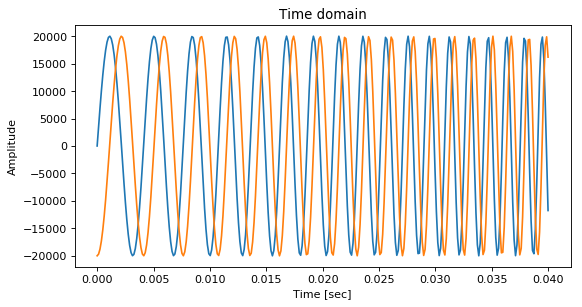

In [5]:
# Upchirp by complex exponential function
plot_wave(chirp(length=0.04), real_only=False)

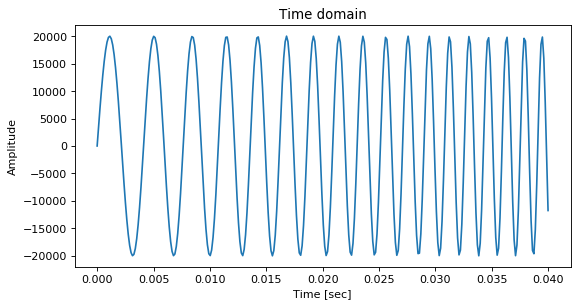

In [6]:
# Upchirp by cosine function
plot_wave(chirp_cos(length=0.04), real_only=True)

In [7]:
play(chirp(length=2.0))

Frequencies at peaks: [232.5 647.5] Hz


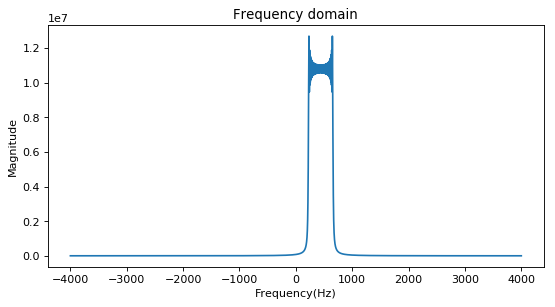

In [8]:
plot_fft(chirp(length=2.0))

Frequencies at peaks: [-647.5 -233.   233.   647.5] Hz


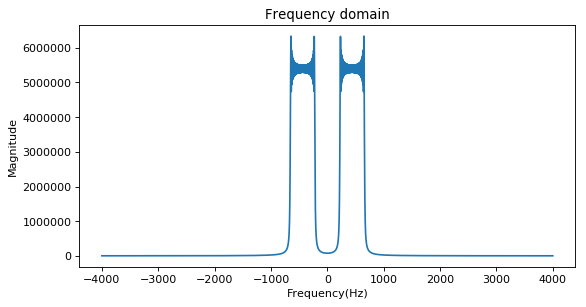

In [9]:
plot_fft(chirp_cos(length=2.0))

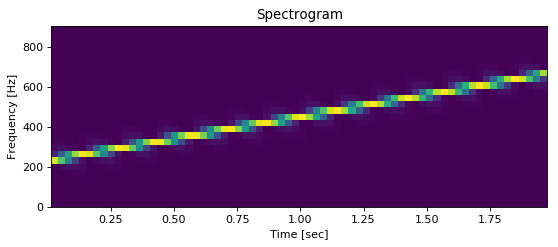

In [10]:
plot_spectrogram(chirp(length=2.0), nperseg=256, band=30)

## Up chirp * up chirp conjugate

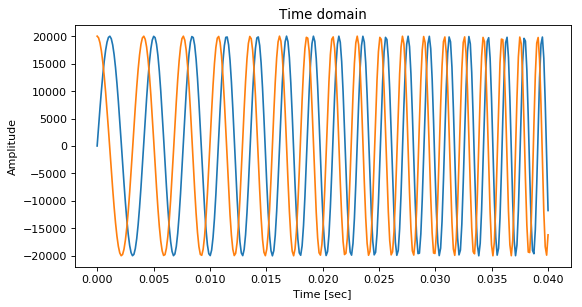

In [11]:
plot_wave(chirp(length=0.04).conjugate(), real_only=False)

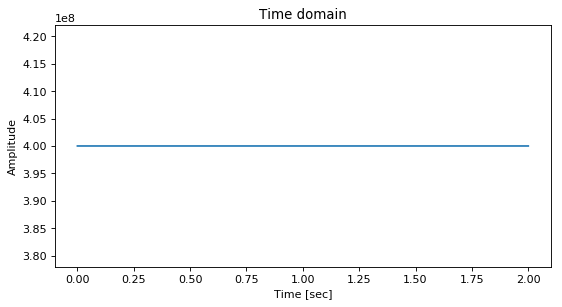

In [12]:
plot_wave(chirp(length=2.0) * chirp(length=2.0).conjugate())

In [13]:
play(chirp(length=2.0) * chirp(length=2.0).conjugate())

Frequencies at peaks: [0.] Hz


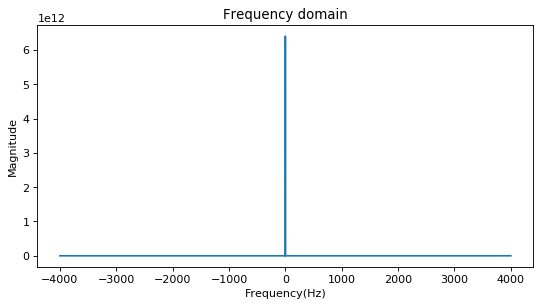

In [14]:
plot_fft(chirp(length=2.0) * chirp(length=2.0).conjugate())

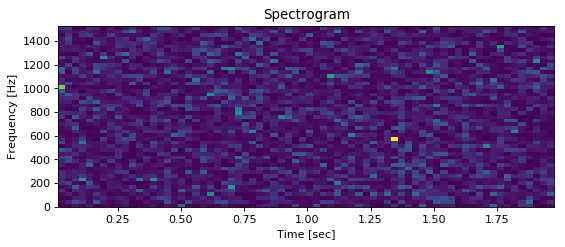

In [15]:
plot_spectrogram(chirp(length=2.0) * chirp(length=2.0).conjugate(), nperseg=256, band=50)

## Up chirp * Down chirp

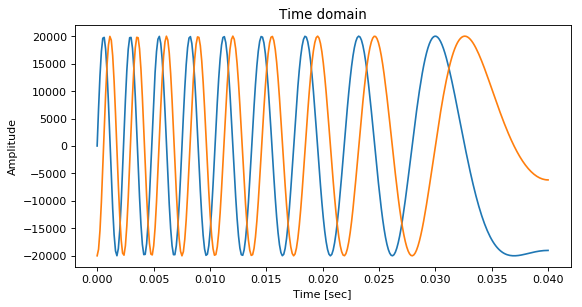

In [16]:
plot_wave(chirp(length=0.04, updown="down"), real_only=False)

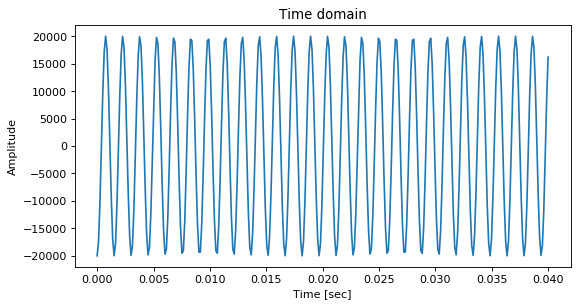

In [17]:
plot_wave(chirp(length=0.04, amp=sqrt(AMPLITUDE)) * chirp(length=0.04, amp=sqrt(AMPLITUDE), updown="down"))

In [18]:
play(chirp(length=2.0, amp=sqrt(AMPLITUDE)) * chirp(length=2.0, amp=sqrt(AMPLITUDE), updown="down"))

Frequencies at peaks: [660.] Hz


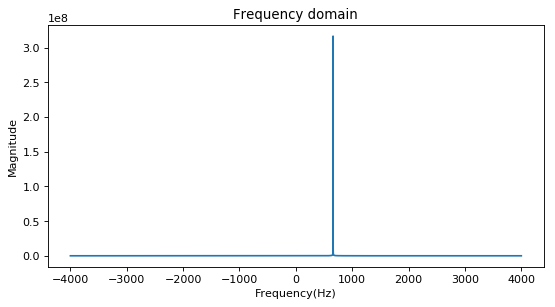

In [19]:
plot_fft(chirp(length=2.0, amp=sqrt(AMPLITUDE)) * chirp(length=2.0, amp=sqrt(AMPLITUDE), updown="down"))

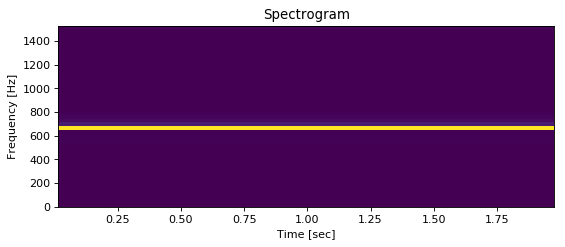

In [20]:
plot_spectrogram(chirp(length=2.0, amp=sqrt(AMPLITUDE)) * chirp(length=2.0, amp=sqrt(AMPLITUDE), updown="down"), nperseg=256, band=50)

## Radar

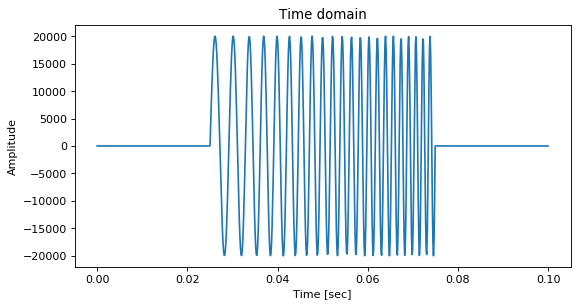

In [21]:
# Upchirp by cosine function (delay = chirp length in time * 0.5)
plot_wave(add_delay(chirp_cos(length=0.05), 0.5), real_only=True)

Frequencies at peaks: [-220.  220.] Hz


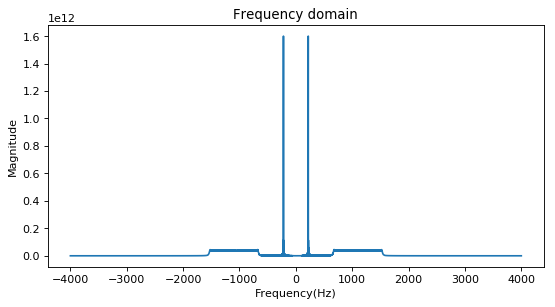

In [22]:
plot_fft(add_delay(chirp_cos(length=2.0), 0.5) * chirp_cos(f1=F1, f2=F1+(F2-F1)*2, length=4.0))

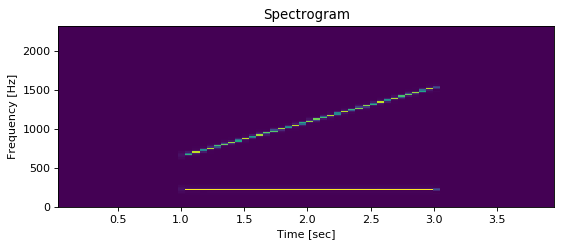

In [23]:
plot_spectrogram(add_delay(chirp_cos(length=2.0), 0.5) * chirp_cos(f1=F1, f2=F1+(F2-F1)*2, length=4.0), nperseg=512, band=150)

Frequencies at peaks: [-220. -132.  -44.   44.  132.  220.] Hz


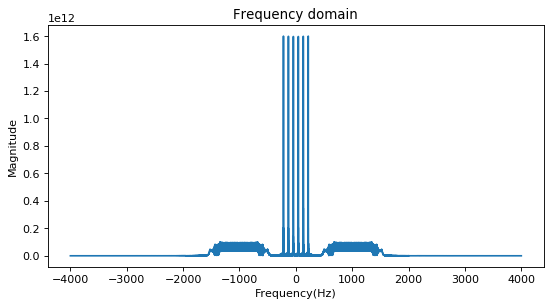

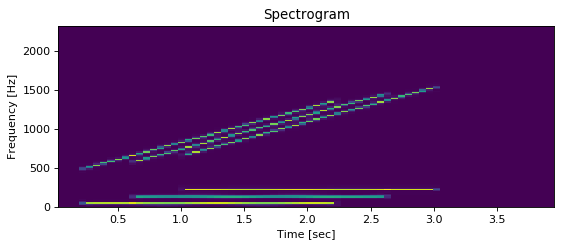

In [24]:
echo0 = add_delay(chirp_cos(length=2.0), 0.1)
echo1 = add_delay(chirp_cos(length=2.0), 0.3)
echo2 = add_delay(chirp_cos(length=2.0), 0.5)
echos = echo0 + echo1 + echo2
plot_fft(echos * chirp_cos(f1=F1, f2=F1+(F2-F1)*2, length=4.0))
plot_spectrogram(echos * chirp_cos(f1=F1, f2=F1+(F2-F1)*2, length=4.0), nperseg=512, band=150)

## Chirp signal under noise level

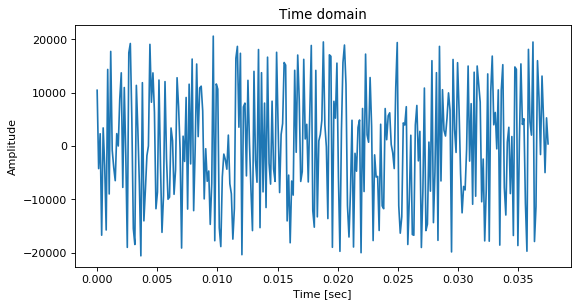

In [27]:
# Chirp signal under noise level (amplitude = 1000, noise amplitude = 20000)
plot_wave((chirp(length=2.0, amp=1000) + white_noise(length=2.0))[0:300], real_only=True)

Frequencies at peaks: [-3784.5 -3686.5  3686.5  3784.5] Hz


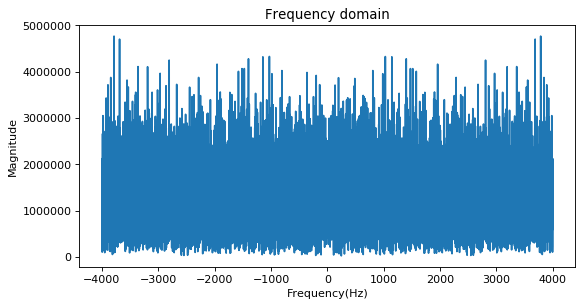

In [30]:
# Chirp signal under noise level (amplitude = 1000, noise amplitude = 20000)
plot_fft((chirp(length=2.0, amp=1000) + white_noise(length=2.0)))

Frequencies at peaks: [0.] Hz


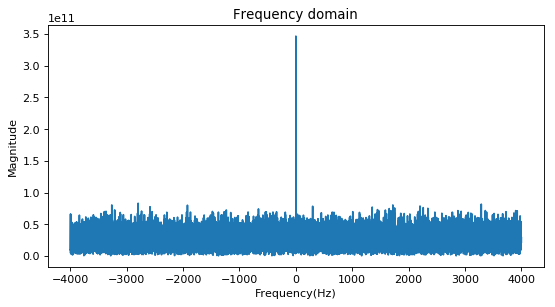

In [31]:
# Chirp signal under noise level (amplitude = 1000, noise amplitude = 20000)
plot_fft((chirp(length=2.0, amp=1000) + white_noise(length=2.0)) * chirp(length=2.0).conjugate())

Frequencies at peaks: [660.] Hz


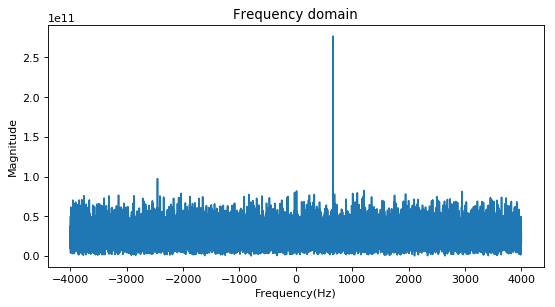

In [32]:
# Chirp signal under noise level (amplitude = 1000, noise amplitude = 20000)
plot_fft((chirp(length=2.0, amp=1000) + white_noise(length=2.0)) * chirp(length=2.0, updown="down"))

Frequencies at peaks: [660.] Hz


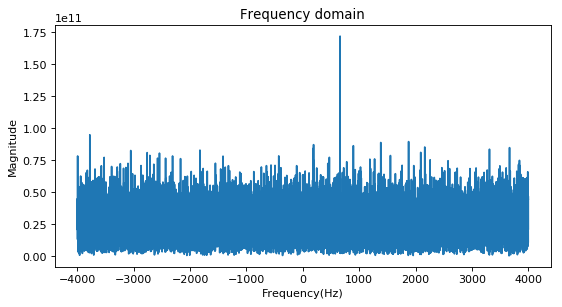

In [33]:
# Real Chirp signal under noise level (amplitude = 1000, noise amplitude = 20000)
plot_fft((real(chirp(length=2.0, amp=1000) + white_noise(length=2.0))) * chirp(length=2.0, updown="down"))

Frequencies at peaks: [660.] Hz


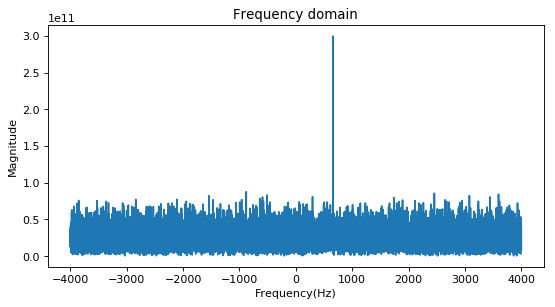

In [34]:
# Real Chirp signal under noise level (amplitude = 2000, noise amplitude = 20000)
plot_fft((real(chirp(length=2.0, amp=2000) + white_noise(length=2.0))) * chirp(length=2.0, updown="down"))

## Stretch chirp (referene "real" chirp signal as matched filter) and compress chirp in frequency domain

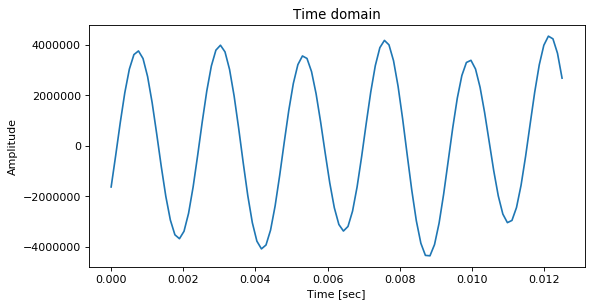

In [37]:
plot_wave(ifft(fft(chirp_cos(length=2.0, amp=sqrt(AMPLITUDE))) * fft(chirp_cos(length=2.0, amp=sqrt(AMPLITUDE))))[0:100])

Frequencies at peaks: [0.] Hz


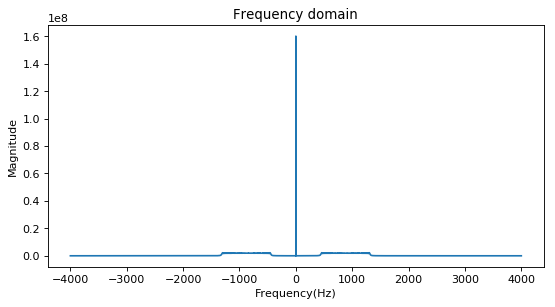

In [38]:
plot_fft(chirp_cos(length=2.0, amp=sqrt(AMPLITUDE)) * chirp_cos(length=2.0, amp=sqrt(AMPLITUDE)))

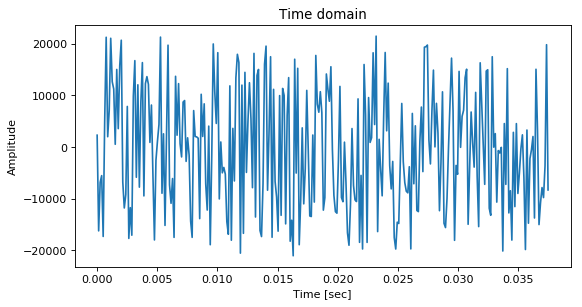

In [39]:
# Real Chirp signal under noise level (amplitude = 2000, noise amplitude = 20000)
plot_wave((chirp_cos(length=2.0, amp=2000) + white_noise(length=2.0))[0:300], real_only=True)

Frequencies at peaks: [-3560.  -3437.5 -2882.5  -439.   -294.    294.    439.   2882.5  3437.5
  3560. ] Hz


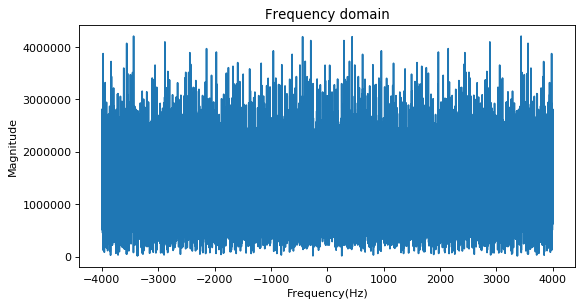

In [41]:
# Real Chirp signal under noise level (amplitude = 2000, noise amplitude = 20000)
plot_fft(chirp_cos(length=2.0, amp=2000) + white_noise(length=2.0))

Frequencies at peaks: [0.] Hz


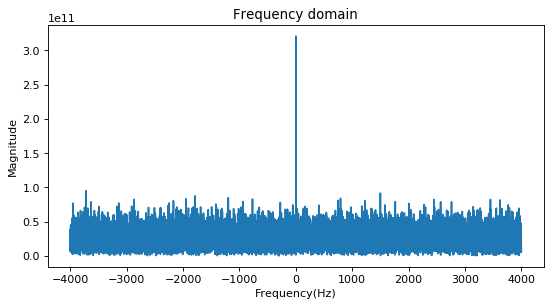

In [42]:
# Real Chirp signal under noise level (amplitude = 2000, noise amplitude = 20000)
plot_fft((chirp_cos(length=2.0, amp=2000) + white_noise(length=2.0)) * chirp(length=2.0))

Frequencies at peaks: [0.] Hz


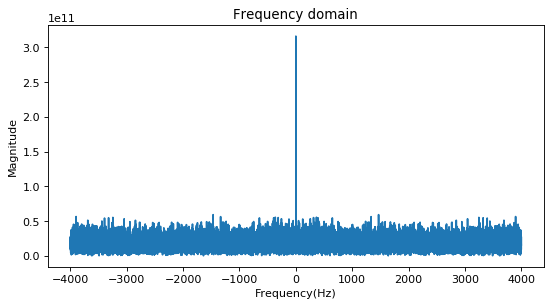

In [44]:
# Real Chirp signal under noise level (amplitude = 2000, noise amplitude = 20000)
plot_fft((chirp_cos(length=2.0, amp=2000) + white_noise(length=2.0)) * chirp_cos(length=2.0))

## Chirp compression in time domain

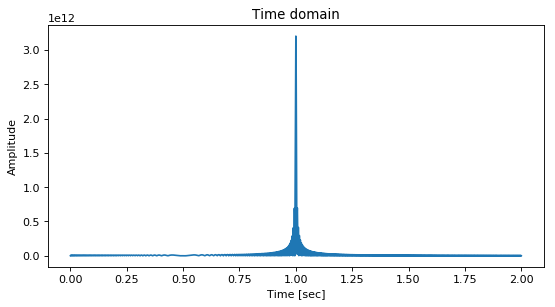

In [45]:
plot_wave(abs(ifft(fft(chirp(length=2.0)) * fft(chirp(length=2.0, updown="down")))), real_only=True)

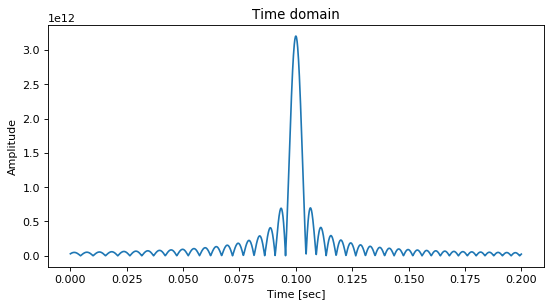

In [46]:
plot_wave(abs(ifft(fft(chirp(length=2.0)) * fft(chirp(length=2.0, updown="down"))))[7200:8800], real_only=True)

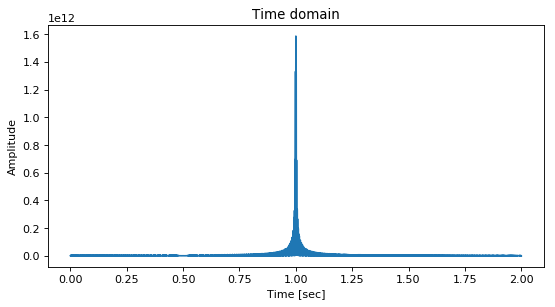

In [47]:
plot_wave(abs(ifft(fft(chirp_cos(length=2.0)) * fft(chirp_cos(length=2.0, updown="down")))), real_only=True)

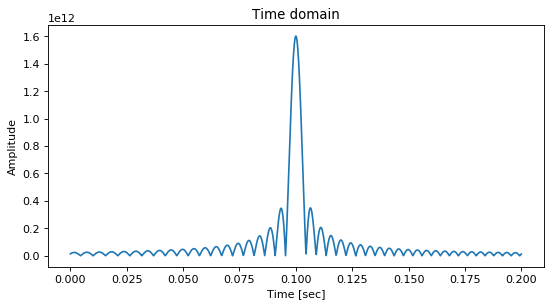

In [48]:
plot_wave(abs(ifft(fft(chirp_cos(length=2.0)) * fft(chirp(length=2.0, updown="down"))))[7200:8800], real_only=True)

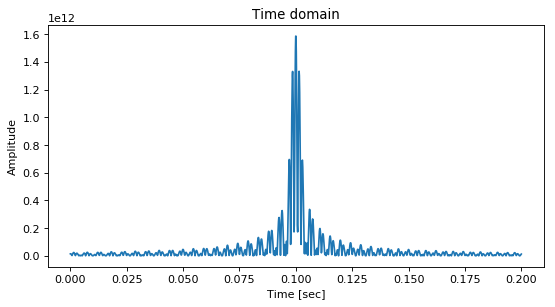

In [49]:
plot_wave(abs(ifft(fft(chirp_cos(length=2.0)) * fft(chirp_cos(length=2.0, updown="down"))))[7200:8800], real_only=True)

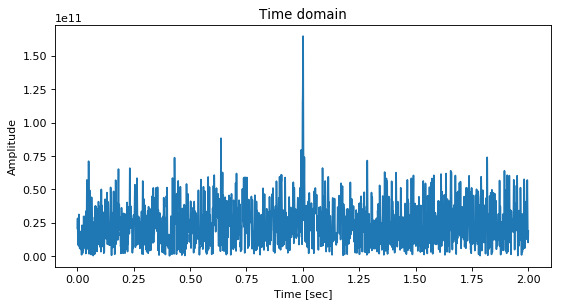

In [50]:
plot_wave(abs(ifft(fft(chirp_cos(length=2.0, amp=2000) + white_noise(length=2.0)) * fft(chirp(length=2.0, updown="down")))), real_only=True)

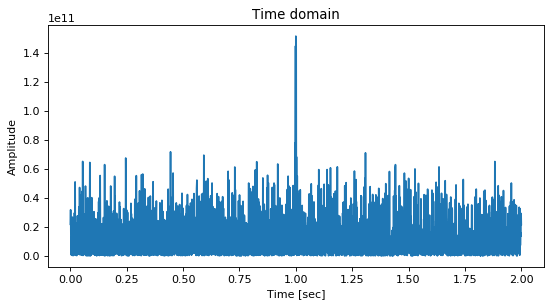

In [51]:
plot_wave(abs(ifft(fft(chirp_cos(length=2.0, amp=2000) + white_noise(length=2.0)) * fft(chirp_cos(length=2.0, updown="down")))), real_only=True)